In [291]:
# libraries
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, generate_binary_structure
from numba import njit

In [292]:
# @njit(nopython = True, nogil = True)
def Lat_Energy(lattice, j1 = 1, j2 = 1):
    # kernal = generate_binary_structure(2, 1) 
    # kernal[1][1] = False
    # kernal[0][0] = True
    # kernal[2][0] = True
    kernal = np.array([[j2, j1, 0], 
                        [j1, 0, j1], 
                        [j2, j1, 0]])
    arr = -lattice*convolve(lattice, kernal, mode = 'wrap', cval = 0)
    '''use mode = 'wrap' if considering infinite/periodic lattice'''
    return np.sum(arr)/2

In [293]:
def nio(lattice):
    for i in range(len(lattice)):
        for j in range(len(lattice)):
            if(i%2 == 0):
                if(j%2 == 0):
                    lattice[i, j] = 0
            if(i%2 == 1):
                if(j%2 == 1):
                    lattice[i, j] = 0      
    return(lattice)  

In [294]:
@njit(nopython = True, nogil = True)
def metropolis(lat_config, n_times, Beta, lattice_energy, N, j1, j2):
    spin_arr = lat_config.copy()
    net_spins = np.zeros(n_times-1)
    net_lattice_energy = np.zeros(n_times-1)

    for t in range(0, n_times-1):

        '''pick random point on array and flip spin'''
        x, y = np.random.randint(low = 0, high = N, size = 2)

        spin_i = spin_arr[x, y]     # initial spin
        # E_i = Lat_Energy(spin_arr)

        # new_spin_arr = spin_arr.copy()
        spin_f = spin_i*(-1)        # flipping initial spin
        # new_spin_arr[x, y] = spin_f
        # E_f = Lat_Energy(new_spin_arr)
        
        '''compute change in lattice_energy'''
        E_i = 0
        E_f = 0

        '''Nearest Neighbors: Conditions are such to accomodate boundary spins'''
        if x > 0:
            E_i += -j1*spin_i*spin_arr[x-1, y-1]
            E_f += -j1*spin_f*spin_arr[x-1, y-1]
            E_i += -j2*spin_i*spin_arr[x, (y-2)]
            E_f += -j2*spin_f*spin_arr[x, (y-2)]
        if x < N-1:
            E_i += -j1*spin_i*spin_arr[x+1, y+1]
            E_f += -j1*spin_f*spin_arr[x+1, y+1]
            E_i += -j2*spin_i*spin_arr[x, (y+2)]
            E_f += -j2*spin_f*spin_arr[x, (y+2)]
        if y > 0:
            E_i += -j1*spin_i*spin_arr[x+1, y-1]
            E_f += -j1*spin_f*spin_arr[x+1, y-1]
            E_i += -j2*spin_i*spin_arr[(x+2), y]
            E_f += -j2*spin_f*spin_arr[(x+2), y]
        if y < N-1:
            E_i += -j1*spin_i*spin_arr[x-1, y+1]
            E_f += -j1*spin_f*spin_arr[x-1, y+1]
            E_i += -j2*spin_i*spin_arr[(x-2), y]
            E_f += -j2*spin_f*spin_arr[(x-2), y]
        # '''Second Nearest Neighbors: Conditions are such to accomodate boundary spins'''

        dE = E_f - E_i
        '''transitioninig to new state with giving probability'''
        if ((dE > 0) and (np.random.random() < np.exp(-Beta*dE))):
            spin_arr[x, y] = spin_f
            lattice_energy += dE
        elif dE <= 0:
            spin_arr[x, y] = spin_f
            lattice_energy += dE
            
        net_spins[t] = spin_arr.sum()
        net_lattice_energy[t] = lattice_energy
    
    final_config = spin_arr.copy()
            
    return net_spins, net_lattice_energy, final_config

c:\Users\jains\AppData\Local\Programs\Python\Python39\lib\site-packages\numba\core\decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [295]:
def get_spin_energy(lattice, BJs, correct_n, N):
    ms = np.zeros(len(BJs))         # array for means of spins
    m_stds = np.zeros(len(BJs))
    e_means = np.zeros(len(BJs))
    e_stds = np.zeros(len(BJs))
    for i, bj in enumerate(BJs):
        spins, energies = metropolis(lattice, 10**6, bj, Lat_Energy(lattice), N)

        # correct_n is the number of spins/particles (from the end of the array) that we'd like to consider to calc. the mean and std. It is like convergence
        ms[i] = np.mean(spins[-correct_n:])/N**2 #.mean()/N**2
        m_stds[i] = np.std(spins[-correct_n:])
        e_means[i] = np.mean(energies[-correct_n:])#.mean()
        e_stds[i] = np.std(energies[-correct_n:])#.std()

    return ms, m_stds, e_means, e_stds

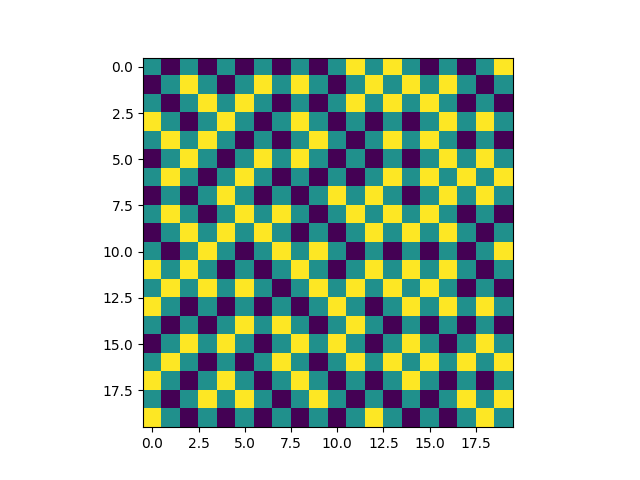

In [296]:
'''Lattice Information'''
N = 20              # NxN lattice
p = 0.5            # Prob of -1 spins
lattice = nio(np.random.choice([-1, 1], size = (N, N), p = [p, 1-p]))
plt.figure("new")
plt.imshow(lattice)

In [307]:
n_steps = 10**6     # Number of times to run metropolis: (randomly) flip spins
j1 = 2.3*10**(-3)
j2 = -21*10**(-3)
energy_lattice = Lat_Energy(lattice, j1, j2)
T = 100
kb = 8.6173303*10**(-5)
B = 1/(T*kb)
spin, enrgy, final = metropolis(lat_config = lattice, n_times = n_steps, Beta = B, lattice_energy = energy_lattice, N = N, j1=2.3*10**(-3), j2=-21*10**(-3))

In [311]:
plt.figure("very")
plt.imshow(final)

print(lat_energy(lattice))

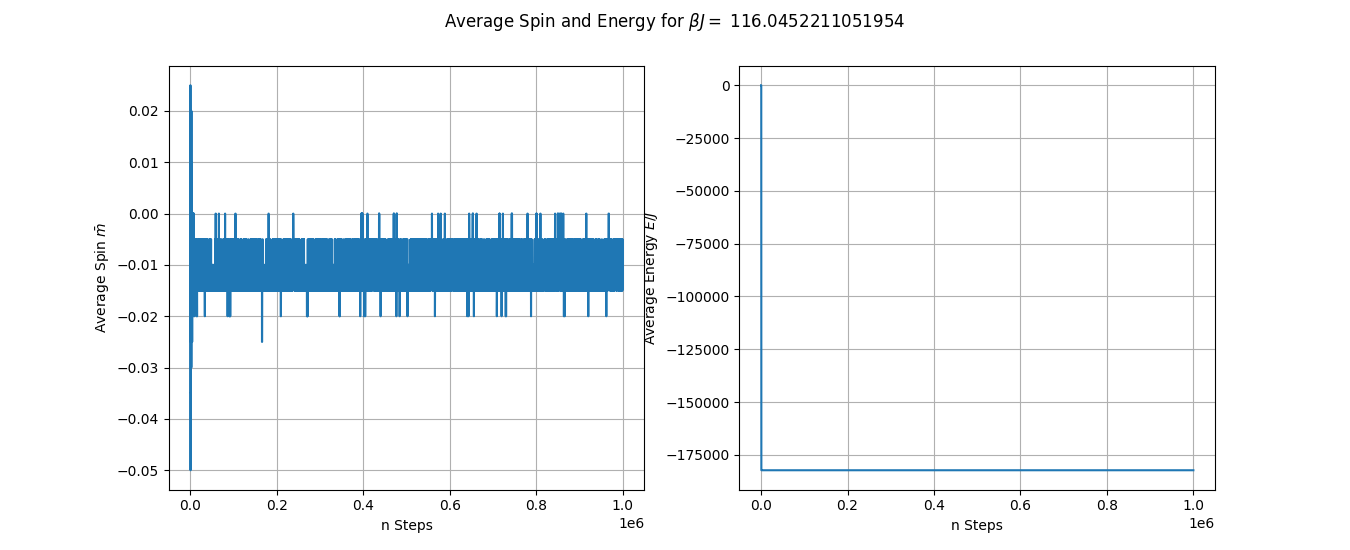

In [309]:
'''Plot of Spins and Energy for particular BJ'''
fig, ax = plt.subplots(1, 2, figsize = (13.5, 5.5)); 
ax[0].plot(spin/(N**2))
ax[0].set_xlabel("n Steps")
ax[0].set_ylabel("Average Spin $\\bar{m}$")
ax[0].grid(True)
ax[1].plot(enrgy/(N**2))
ax[1].set_xlabel("n Steps")
ax[1].set_ylabel("Average Energy $E/J$")
ax[1].grid(True)
fig.suptitle("Average Spin and Energy for $\\beta J = $ {:}".format(B), size = 12); 

In [300]:
# '''Plot of Spins and Energy for particular BJ'''
# fig, ax = plt.subplots(1, 2, figsize = (13.5, 5.5)); 
# ax[0].plot(spin/N**2)
# ax[0].set_xlabel("n Steps")
# ax[0].set_ylabel("Average Spin $\\bar{m}$")
# ax[0].grid(True)
# ax[1].plot(enrgy/N**2)
# ax[1].set_xlabel("n Steps")
# ax[1].set_ylabel("Average Energy $E/J$")
# ax[1].grid(True)
# fig.suptitle("Average Spin and Energy for $\\beta J = $ {:}".format(BJ), size = 12); 

<hr/>

In [301]:
# BJs = np.linspace(0.05, 20, 200)
# s_means, s_stds, E_means, E_stds = get_spin_energy(lattice, BJs, 10**5, N)

In [302]:
# '''Plot of Magnetization and Cv vs 1/BJ'''
# fig2, ax2 = plt.subplots(1, 2, figsize = (13.5, 5.5)); 
# # ms_max_ind = np.argmax(s_means)
# ax2[0].plot(1/BJs, s_means, ls = '--', marker = ".")
# # ax2[0].axvline(1/BJs[ms_max_ind], color = "black", label = "1/BJ = {:.5}".format(1/BJs[ms_max_ind]))
# ax2[0].set_xlabel("$1/\\beta J$")
# ax2[0].set_ylabel("$\\bar{m}$")
# ax2[0].grid()
# # ax2[0].legend()

# cv_max_ind = np.argmax(E_stds*BJs)
# ax2[1].plot(1/BJs, E_stds*BJs, ls = "-.", marker = "o")
# ax2[1].axvline(1/BJs[cv_max_ind], color = "black", label = "1/BJ = {:.5}".format(1/BJs[cv_max_ind]))
# ax2[1].set_xlabel("$1/\\beta J$")
# ax2[1].set_ylabel("$C_V / k^2$")
# ax2[1].grid()
# ax2[1].legend()
# fig2.suptitle("Mean Magnetization and Specific Heat\n{:}% of spins started negative".format(int(p*100))); 

In [303]:
# BJc = np.arange(0.4, 0.62, 0.002)
# s_means_crit, E_means_crit, E_stds_crit = get_spin_energy(lattice, BJc, 10**5, N)

In [304]:
# '''Near Critical Point'''
# fig3, ax3 = plt.subplots(1, 2, figsize = (13.5, 5.5)); 
# ax3[0].plot(1/BJc, s_means_crit, ls = '--', marker = ".")
# ax3[0].set_xlabel("$1/\\beta J$")
# ax3[0].set_ylabel("$\\bar{m}$")
# ax3[0].grid()

# cv_max_ind = np.argmax(E_stds_crit*BJc)
# ax3[1].plot(1/BJc, E_stds_crit*BJc, ls = "-.", marker = "o")
# ax3[1].axvline(1/BJc[cv_max_ind], color = "black", label = "1/BJ = {:.5}".format(1/BJc[cv_max_ind]))
# ax3[1].set_xlabel("$1/\\beta J$")
# ax3[1].set_ylabel("$C_V / k^2$")
# ax3[1].grid()
# ax3[1].legend()
# fig3.suptitle("Near Critical Point"); 

<hr/>

In [305]:
# '''Comparing Positive and Negative Lattices'''
# lattice_n = np.random.choice([-1, 1], size = (N, N), p = [p, 1-p])
# lattice_p = np.random.choice([-1, 1], size = (N, N), p = [1-p, p])
# ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs, 10**5, N)
# ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs, 10**5, N)

In [306]:
# fig3, ax3 = plt.subplots(1, 2, figsize = (13.5, 5.5)); 

# ax3[0].plot(1/BJs, ms_n, "o--", label = "{:}% of spins started negative".format(int(p*100)))
# ax3[0].plot(1/BJs, ms_p, "o--", label = "{:}% of spins started positive".format(int(p*100)))
# ax3[0].set_xlabel("$1/\\beta J$")
# ax3[0].set_ylabel("$\\bar{m}$")
# ax3[0].grid()
# ax3[0].legend()

# ax3[1].plot(1/BJs, E_stds_n*BJs, label = "{:}% of spins started negative".format(int(p*100)))
# ax3[1].plot(1/BJs, E_stds_p*BJs, label = "{:}% of spins started positive".format(int(p*100)))
# ax3[1].set_xlabel("$1/\\beta J$")
# ax3[1].set_ylabel("$C_V / k^2$")
# ax3[1].grid()
# ax3[1].legend()